In [83]:
#https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/03_scRNA-seq_data_preprocessing/scanpy_preprocessing_with_Paul_etal_2015_data.ipynb

#0. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc


In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pl.rcParams["savefig.dpi"] = 300
pl.rcParams["figure.figsize"] = [6, 4.5]

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/FCneg_mouse2.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                 8.2.0
anyio               NA
appnope             0.1.2
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
cairo               1.20.1
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask  

In [3]:
#1. Load data: Download dataset.

FCneg_mouse2 = sc.read_excel('/Users/sadeq/Desktop/scanpy-practice/TestData/Preselected_GSE152632_counts_FCneg_Mouse2.xlsx','Preselected_GSE152632_Transpose')

In [4]:
FCneg_mouse2

AnnData object with n_obs × n_vars = 192 × 15999

In [5]:
#2. Filtering
# Only consider genes with more than 1 count
sc.pp.filter_genes(FCneg_mouse2, min_counts=1)

filtered out 190 genes that are detected in less than 1 counts


In [6]:
#3. Normalization
# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(FCneg_mouse2, key_n_counts='n_counts_all')

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts_all', counts per cell before normalization (adata.obs)


In [7]:
FCneg_mouse2

AnnData object with n_obs × n_vars = 192 × 15809
    obs: 'n_counts_all'
    var: 'n_counts'

In [8]:
#4. Identification of highly variable genes
# Select top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(FCneg_mouse2.X,flavor='cell_ranger', n_top_genes=2000, log=False)

# Subset the genes
FCneg_mouse2 = FCneg_mouse2[:, filter_result.gene_subset]

# Renormalize after filtering
sc.pp.normalize_per_cell(FCneg_mouse2)

extracting highly variable genes
    finished (0:00:00)
normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [9]:
#5. Log transformation
# keep raw cont data before log transformation

FCneg_mouse2.raw = FCneg_mouse2
FCneg_mouse2.layers["raw_count"] = FCneg_mouse2.raw.X.copy()


# Log transformation and scaling
sc.pp.log1p(FCneg_mouse2)
sc.pp.scale(FCneg_mouse2)

In [10]:
#6. PCA and neighbor calculations
# PCA
sc.tl.pca(FCneg_mouse2, svd_solver='arpack')

# Diffusion map
sc.pp.neighbors(FCneg_mouse2, n_neighbors=4, n_pcs=20)
sc.tl.diffmap(FCneg_mouse2)

# Calculate neihbors again based on diffusionmap 
sc.pp.neighbors(FCneg_mouse2, n_neighbors=10, use_rep='X_diffmap')

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.99999994 0.99466723 0.99046683 0.9869749
     0.9767775  0.9588475  0.9577447  0.94827294 0.93936974 0.93215954
     0.931078   0.92558163 0.92286247]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


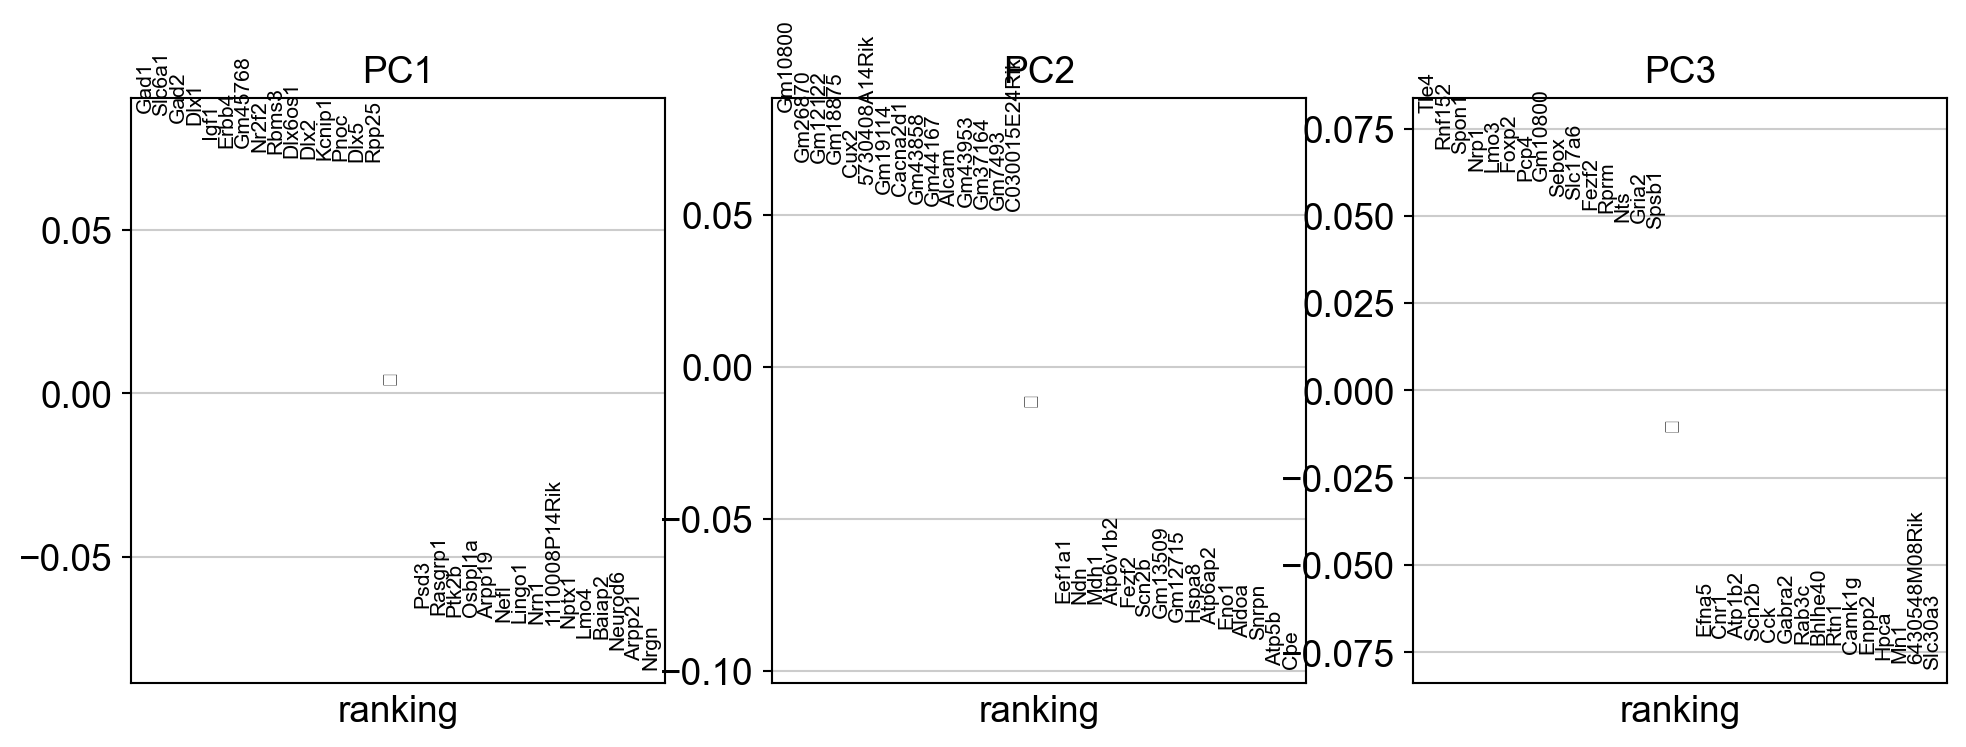

In [14]:
sc.settings.set_figure_params(dpi=95)  #it create plots larger, not the smashed ones that generate by default!
sc.pl.pca_loadings(FCneg_mouse2)

In [55]:
#7. Cell clustering
# clustering can be done either leiden or louvain. make sure you import them first.
pip install louvain

     |████████████████████████████████| 210 kB 3.2 MB/s            
     |████████████████████████████████| 1.8 MB 1.3 MB/s            
You should consider upgrading via the '/Users/sadeq/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [56]:
#7. Cell clustering
sc.tl.louvain(FCneg_mouse2, resolution=0.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/sadeq/opt/anaconda3/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [57]:
#8. Dimensionality reduction using PAGA and force-directed graphs
# PAGA graph construction
sc.tl.paga(FCneg_mouse2, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


In [91]:
pl.rcParams["figure.figsize"] = [6, 4.5]

--> added 'pos', the PAGA positions (adata.uns['paga'])


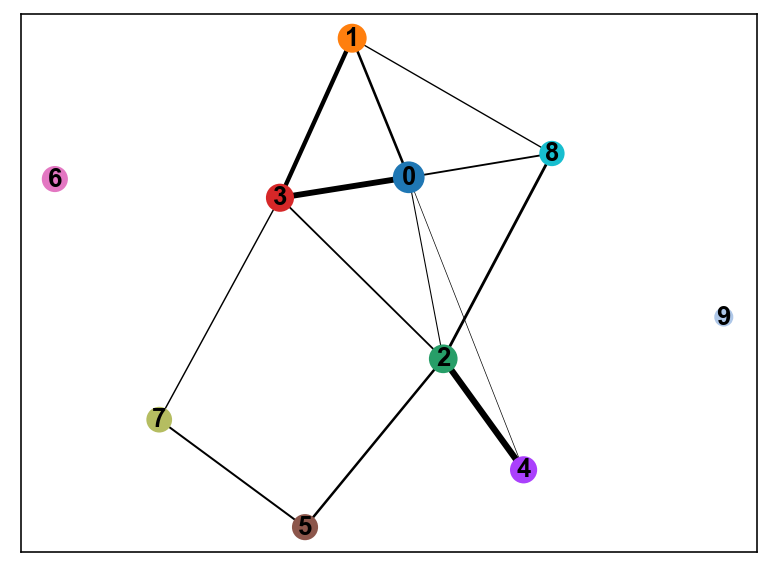

In [92]:
sc.pl.paga(FCneg_mouse2)

In [23]:
sc.tl.draw_graph(FCneg_mouse2, init_pos='paga', random_state=123)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


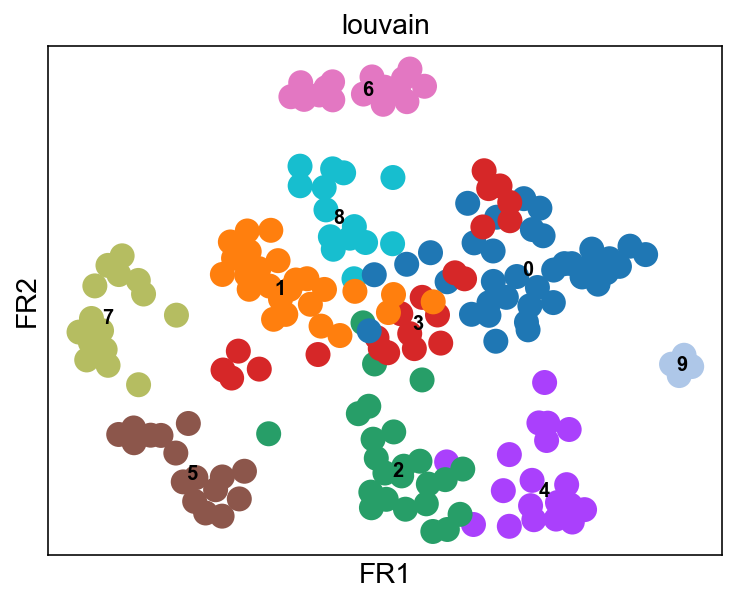

In [58]:
sc.pl.draw_graph(FCneg_mouse2, color='louvain', legend_loc='on data')

In [24]:
#9. Check data
#9.1. Visualize marker gene expression

pl.rcParams["figure.figsize"] = [4.5, 4.5]

marker gene of Neouron_cells


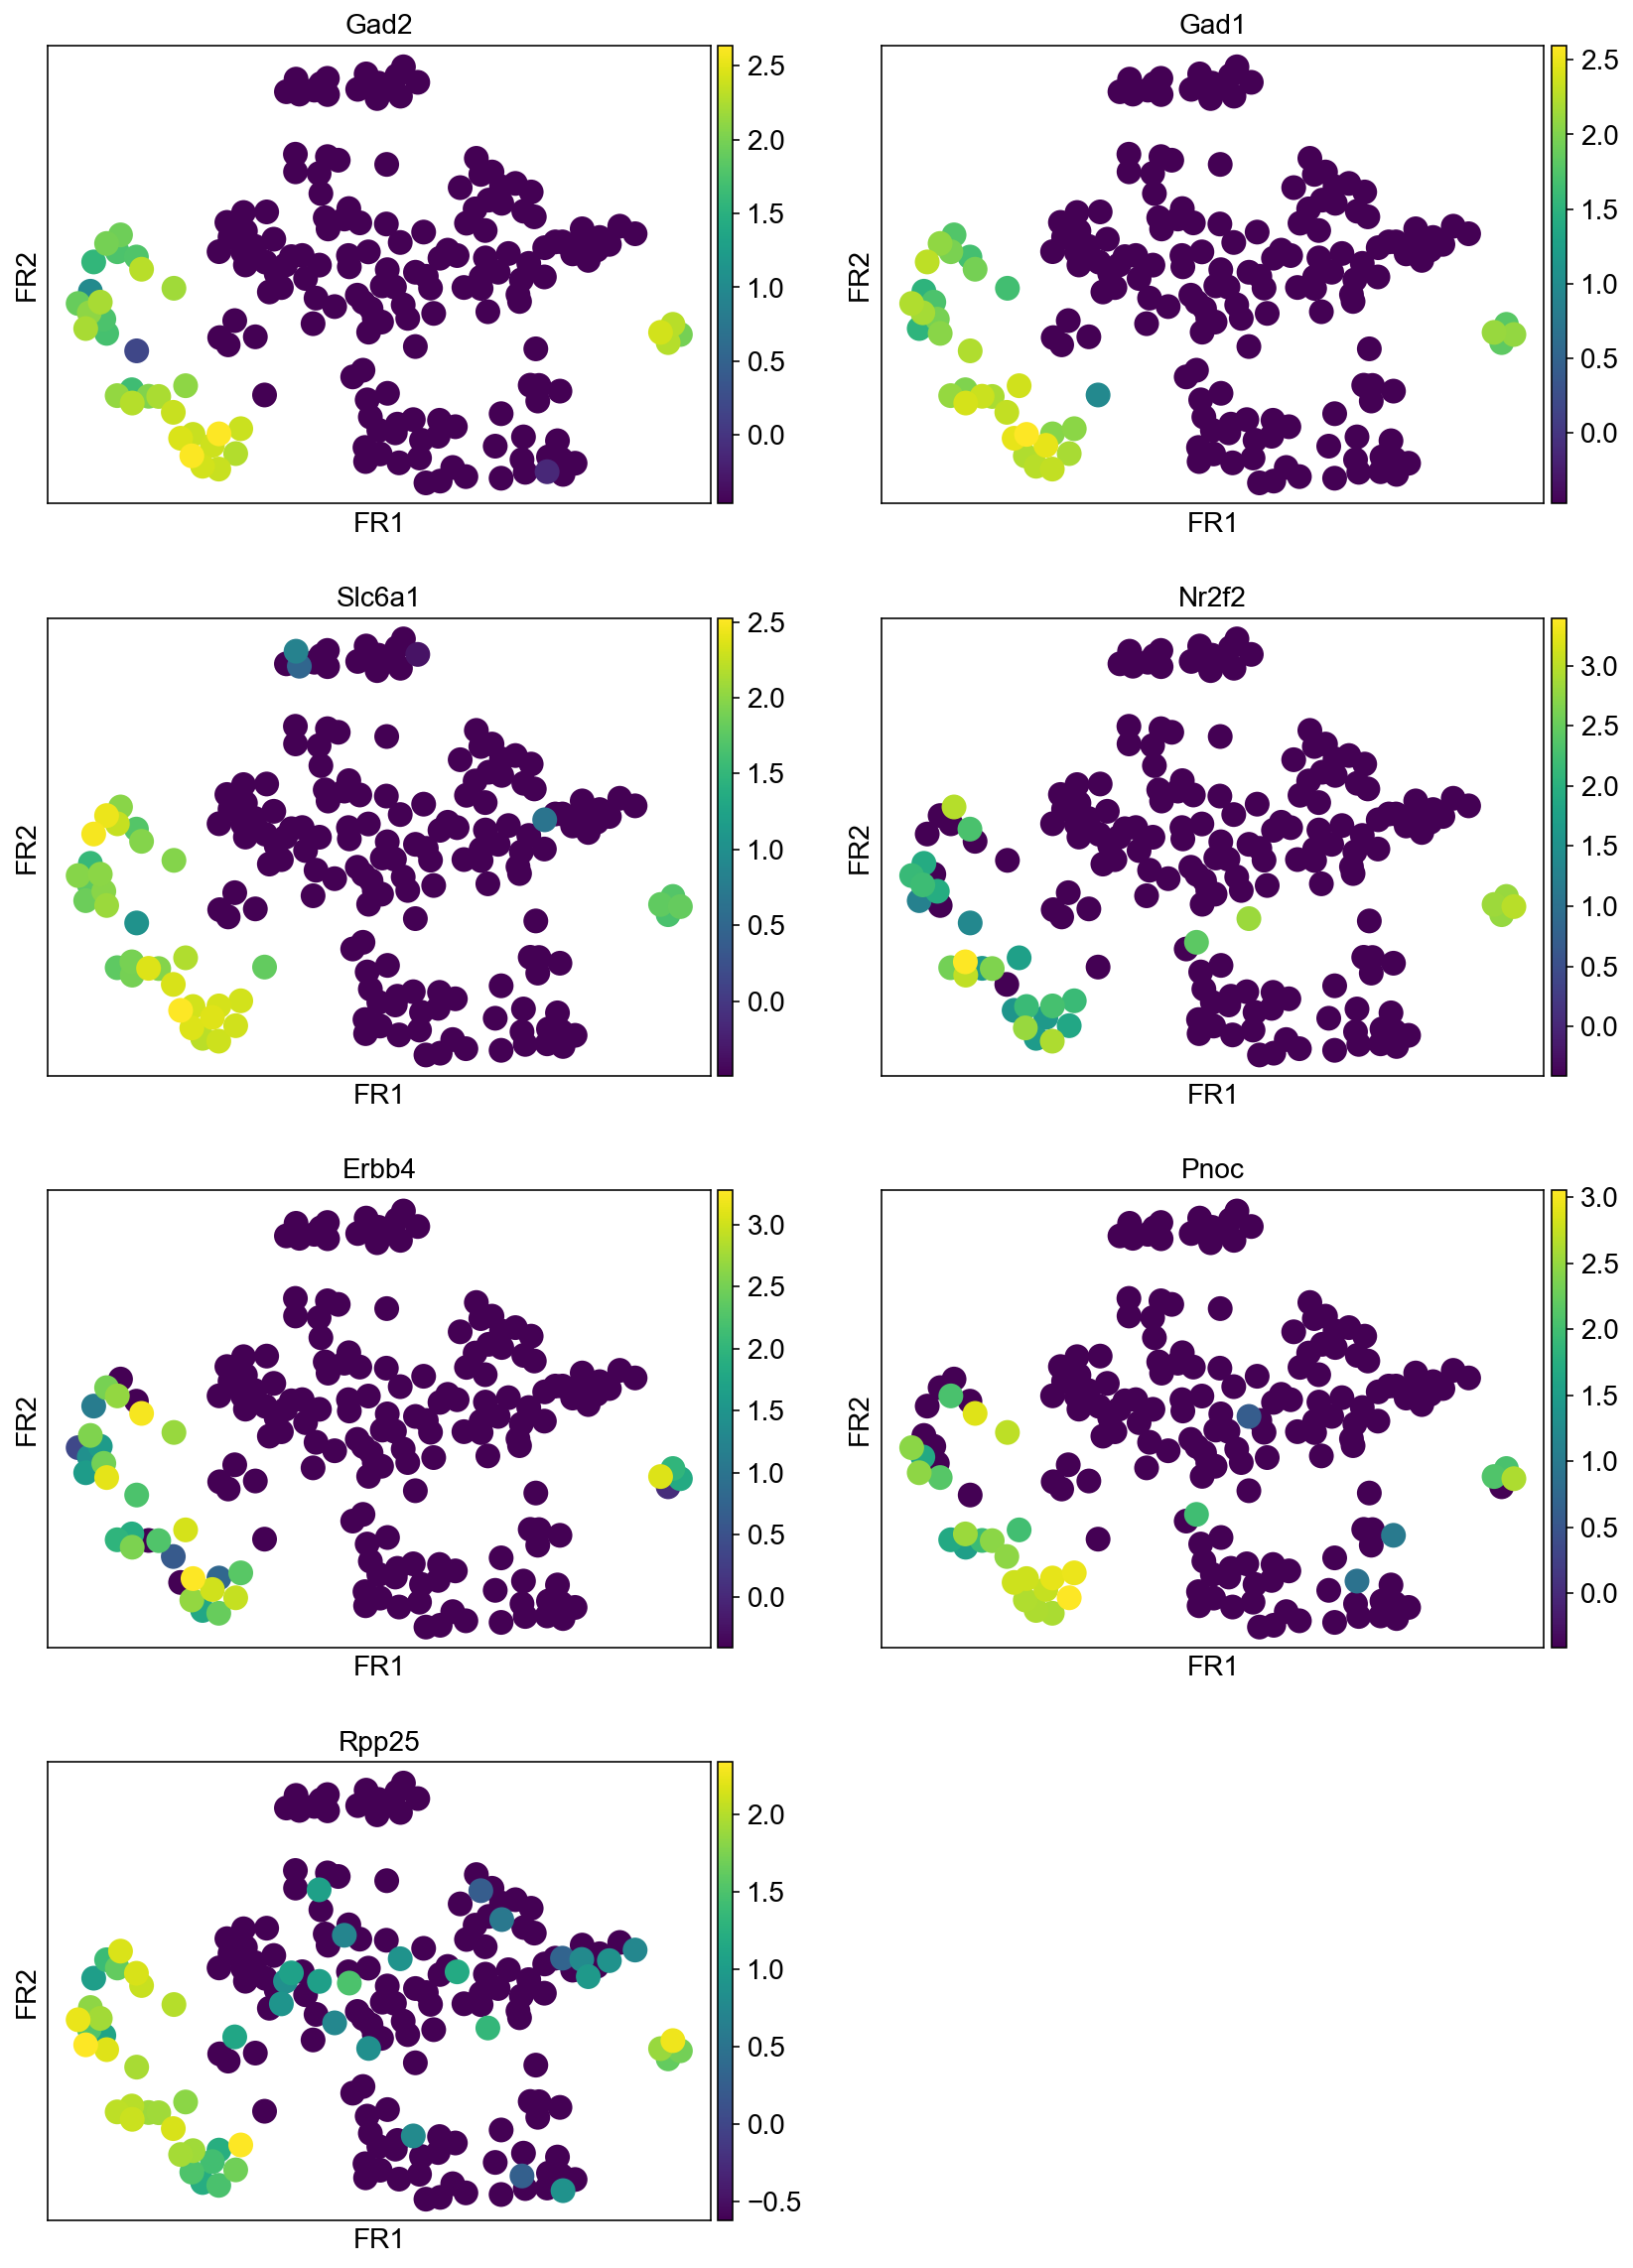

marker gene of Astrocyte


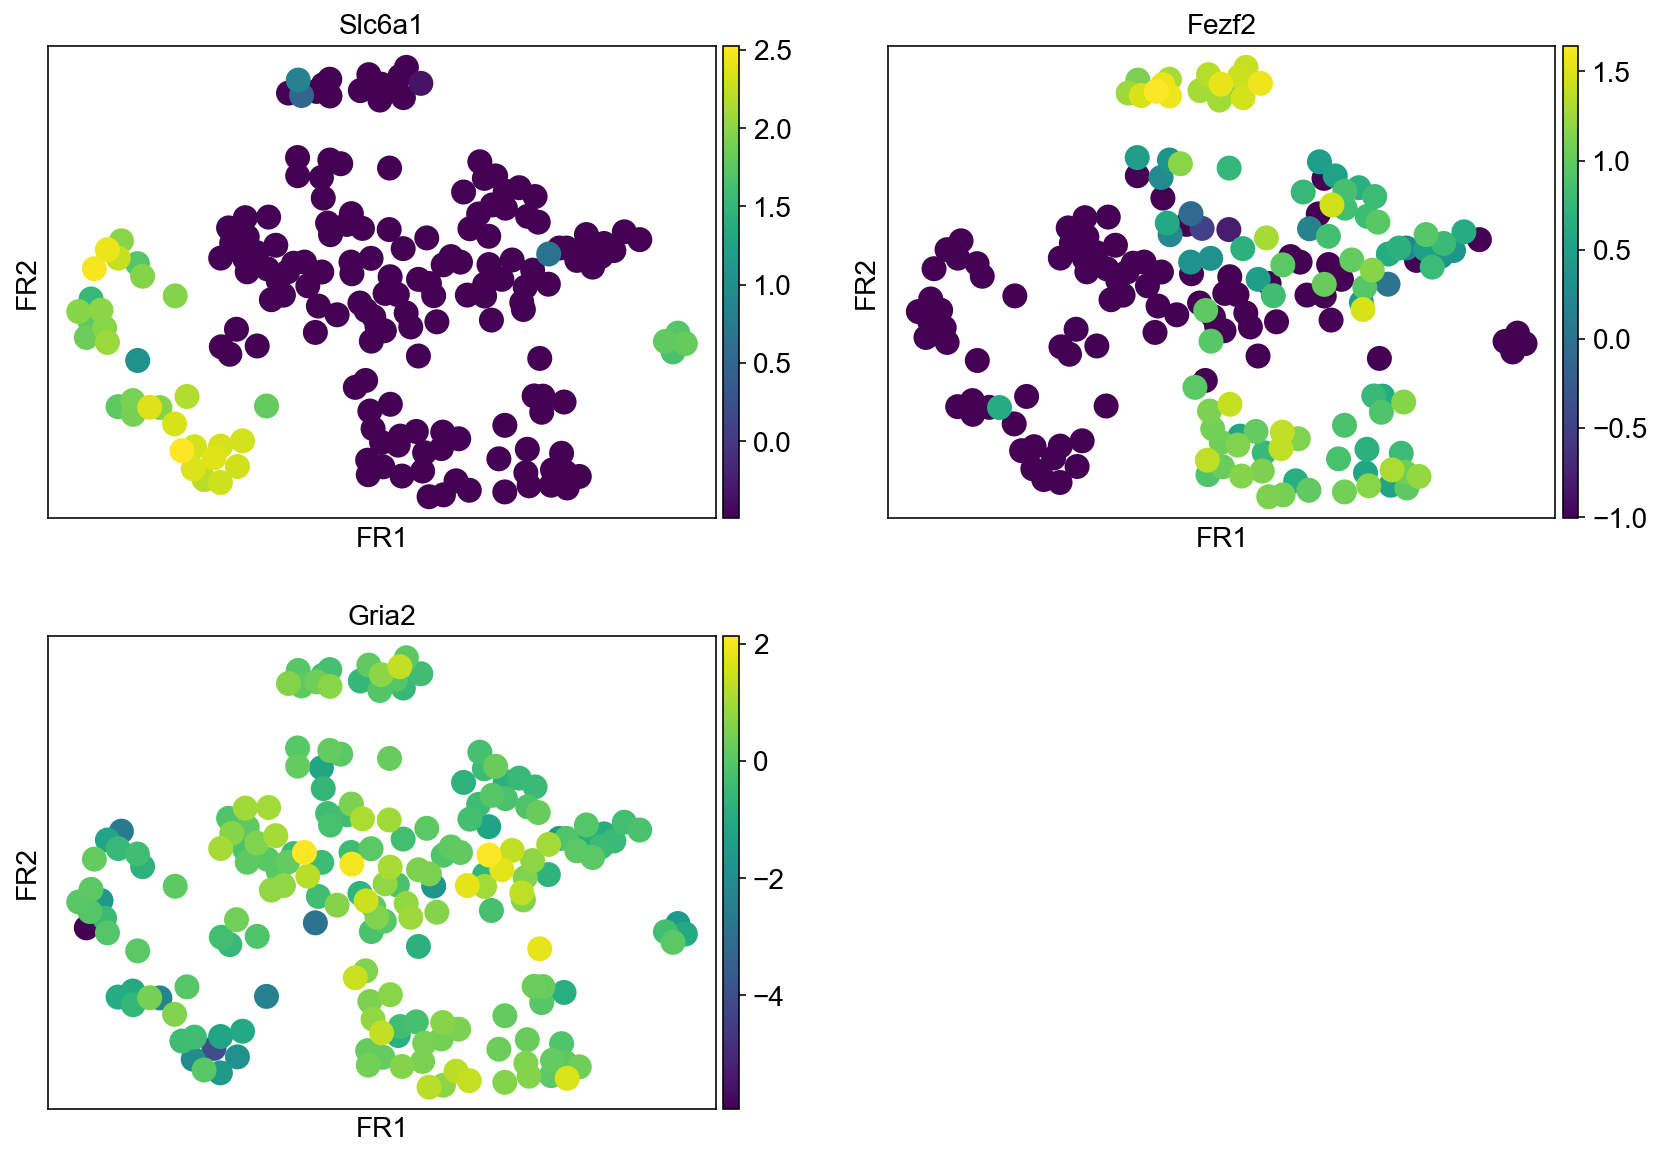

marker gene of Endothelia_Cell


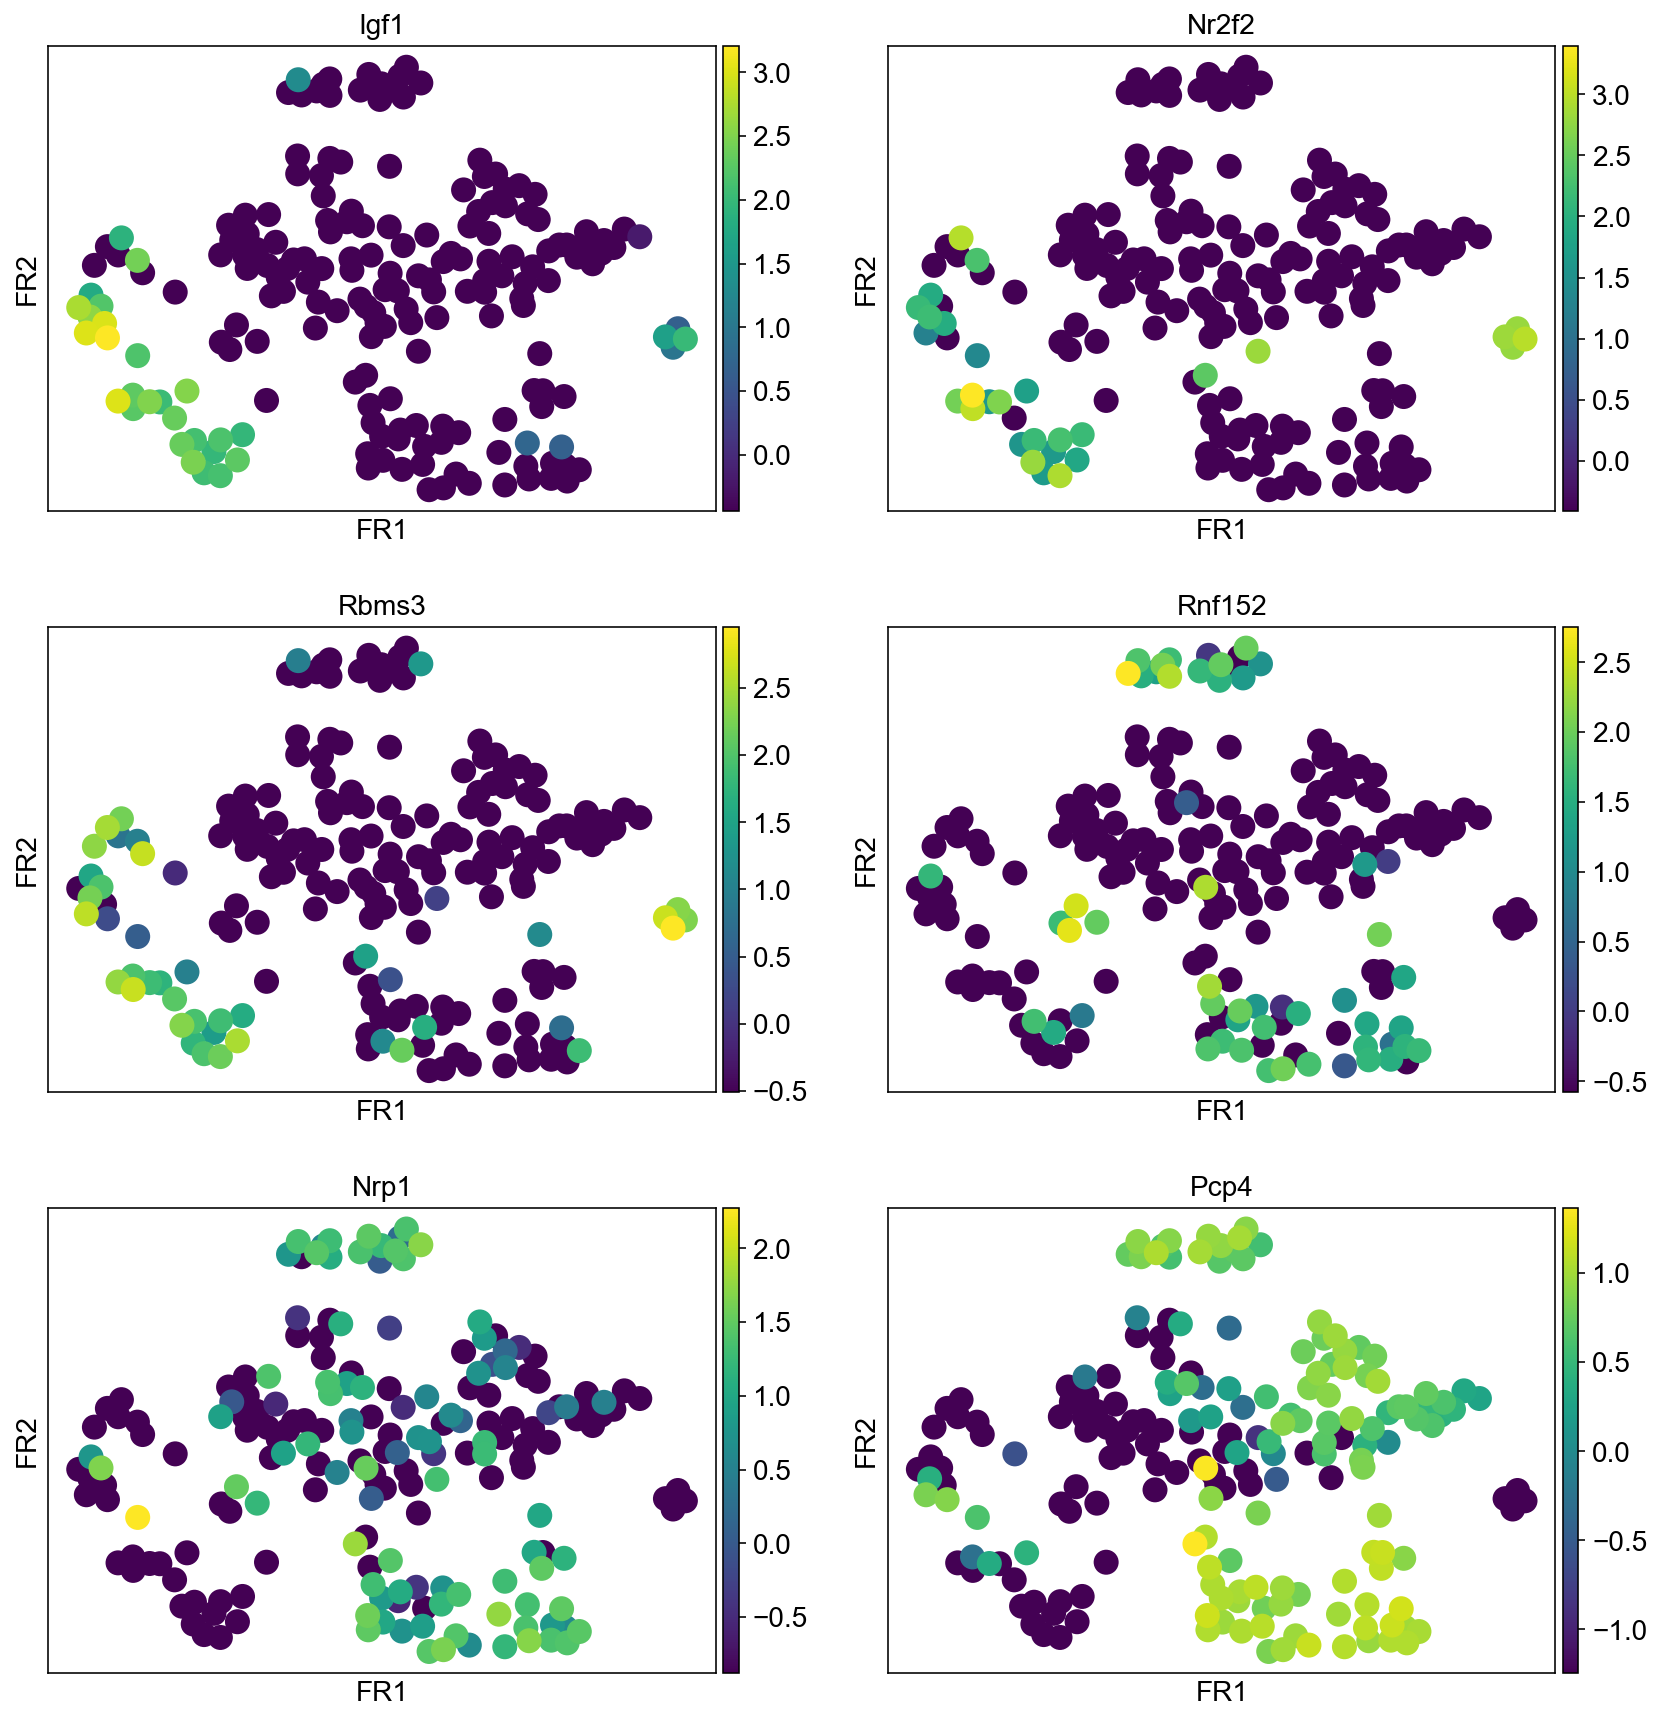

marker gene of Oligodendrocyte_Precursor_Cell


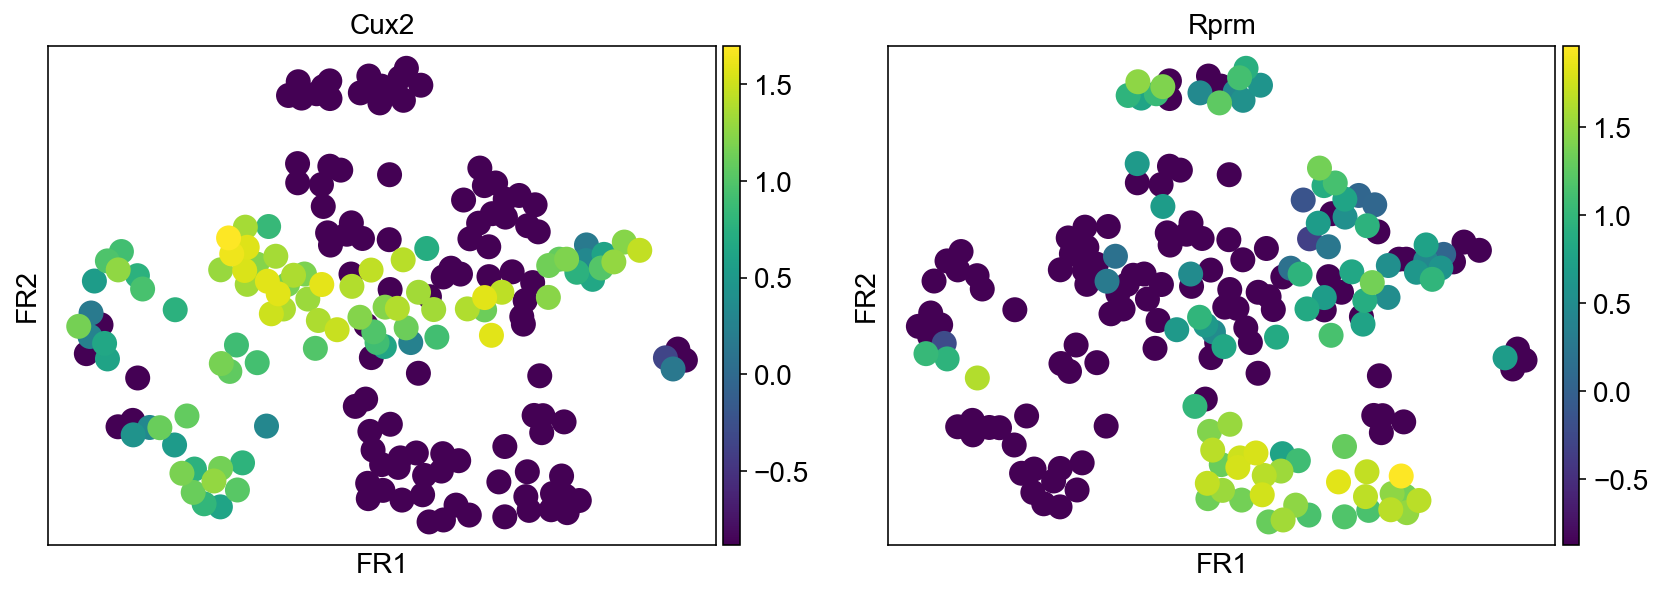

marker gene of Mast_cells


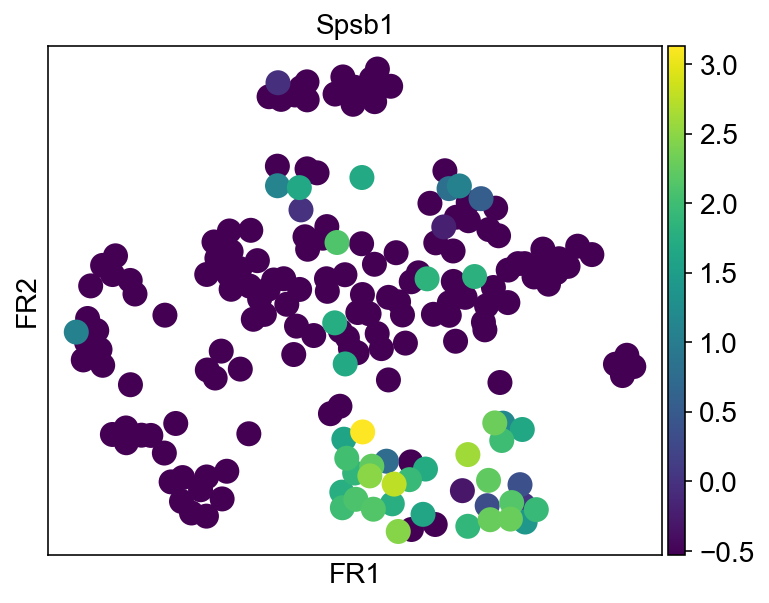

marker gene of Basophils


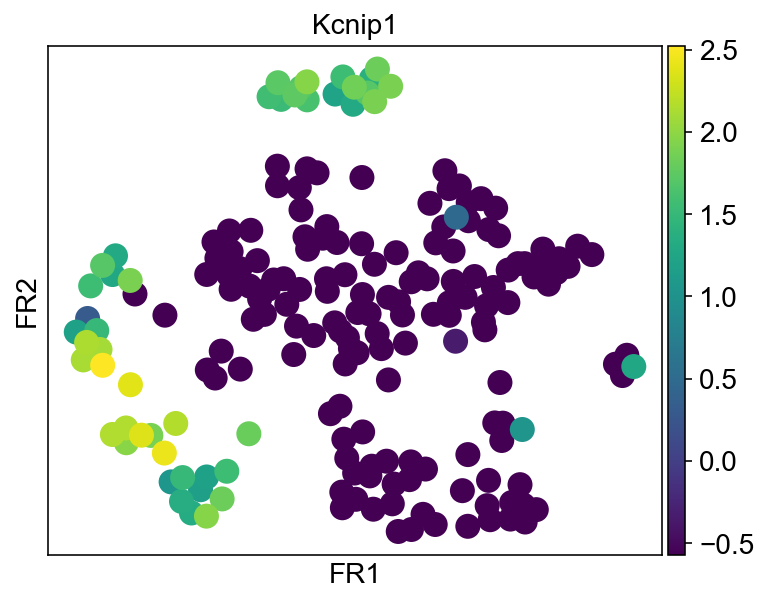

marker gene of Oligodendrocyte


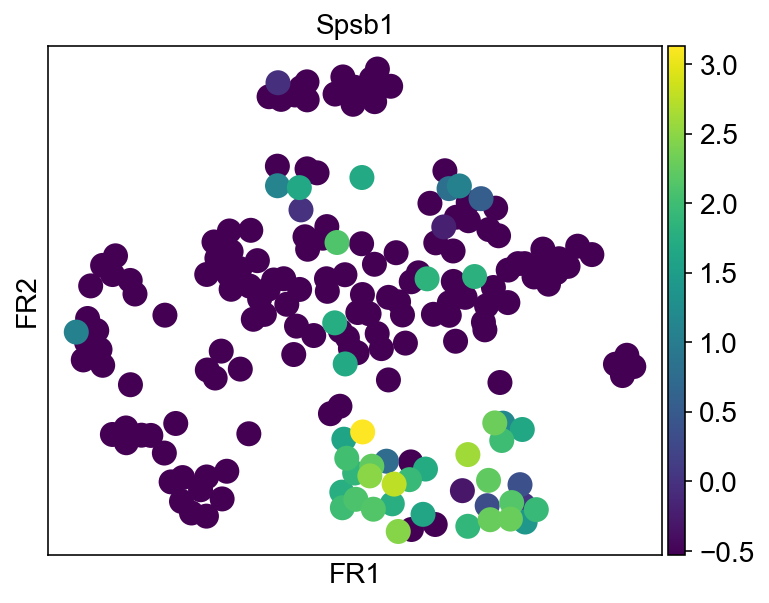

In [93]:
#I selected my marker genes based on PCA loadings and availble data of Top ranked cell type(neuron)-enriched genes in https://www.nature.com/articles/s41598-018-27293-5. 
markers = {"Neouron_cells":["Gad2","Gad1","Slc6a1","Nr2f2","Erbb4","Pnoc","Rpp25"], 
           "Astrocyte":["Slc6a1","Fezf2","Gria2"],
            "Endothelia_Cell":["Igf1","Nr2f2","Rbms3","Rnf152","Nrp1","Pcp4"],
            "Oligodendrocyte_Precursor_Cell":["Cux2","Rprm"],
            "Mast_cells":["Spsb1"],
            "Basophils":["Kcnip1"], "Oligodendrocyte":["Spsb1"]}
for cell_type, genes in markers.items():
    print(f"marker gene of {cell_type}")
    sc.pl.draw_graph(FCneg_mouse2, color=genes, use_raw=False, ncols=2)
    pl.show()

In [94]:
sc.pp.neighbors(FCneg_mouse2, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(FCneg_mouse2)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


In [96]:
#9. make annotation
# Check current cluster name
cluster_list = FCneg_mouse2.obs.leiden.unique()
cluster_list

['1', '2', '14', '0', '7', ..., '8', '11', '10', '12', '13']
Length: 15
Categories (15, object): ['1', '2', '14', '0', ..., '11', '10', '12', '13']

In [113]:
# Make cluster anottation dictionary
annotation = {"MEP":[5],
              "Erythroids": [15, 10, 16, 9, 8, 14, 19, 3, 12, 18],
              "Megakaryocytes":[17, 22],  
              "GMP":[11, 1],
              "late_GMP" :[0],   
              "Granulocytes":[7, 13, 4],
              "Monocytes":[6, 2],
              "DC":[21],
              "Lymphoid":[20],
             "Neuron_cells":[10]}

# Change dictionary format
annotation_rev = {}
for i in cluster_list:
    for k in annotation:
        if int(i) in annotation[k]:
            annotation_rev[i] = k
            
# Check dictionary
annotation_rev

{'1': 'GMP',
 '2': 'Monocytes',
 '14': 'Erythroids',
 '0': 'late_GMP',
 '7': 'Granulocytes',
 '3': 'Erythroids',
 '9': 'Erythroids',
 '5': 'MEP',
 '6': 'Monocytes',
 '4': 'Granulocytes',
 '8': 'Erythroids',
 '11': 'GMP',
 '10': 'Neuron_cells',
 '12': 'Erythroids',
 '13': 'Granulocytes'}

In [114]:
FCneg_mouse2.obs["cell_type"] = [annotation_rev[i] for i in FCneg_mouse2.obs.leiden]

Trying to set attribute `.obs` of view, copying.


... storing 'cell_type' as categorical


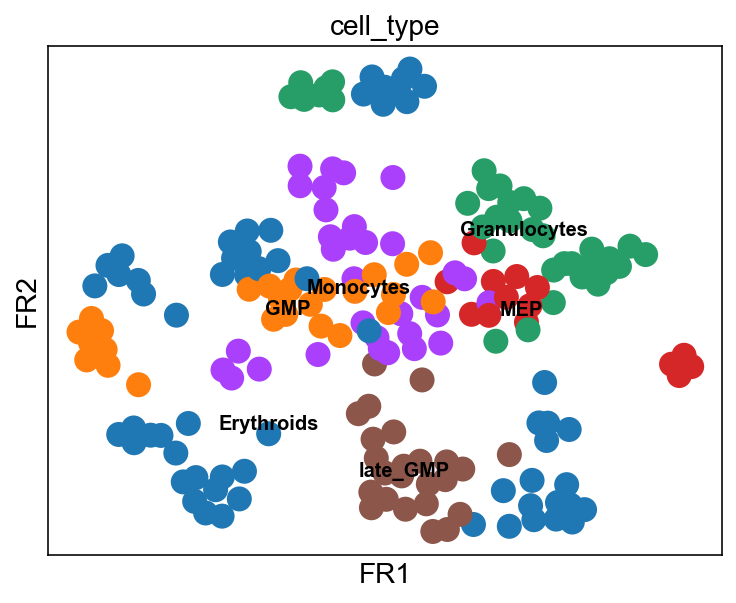

In [103]:
# check results
sc.pl.draw_graph(FCneg_mouse2, color=['cell_type'],
                 legend_loc='on data')

... storing 'cell_type' as categorical


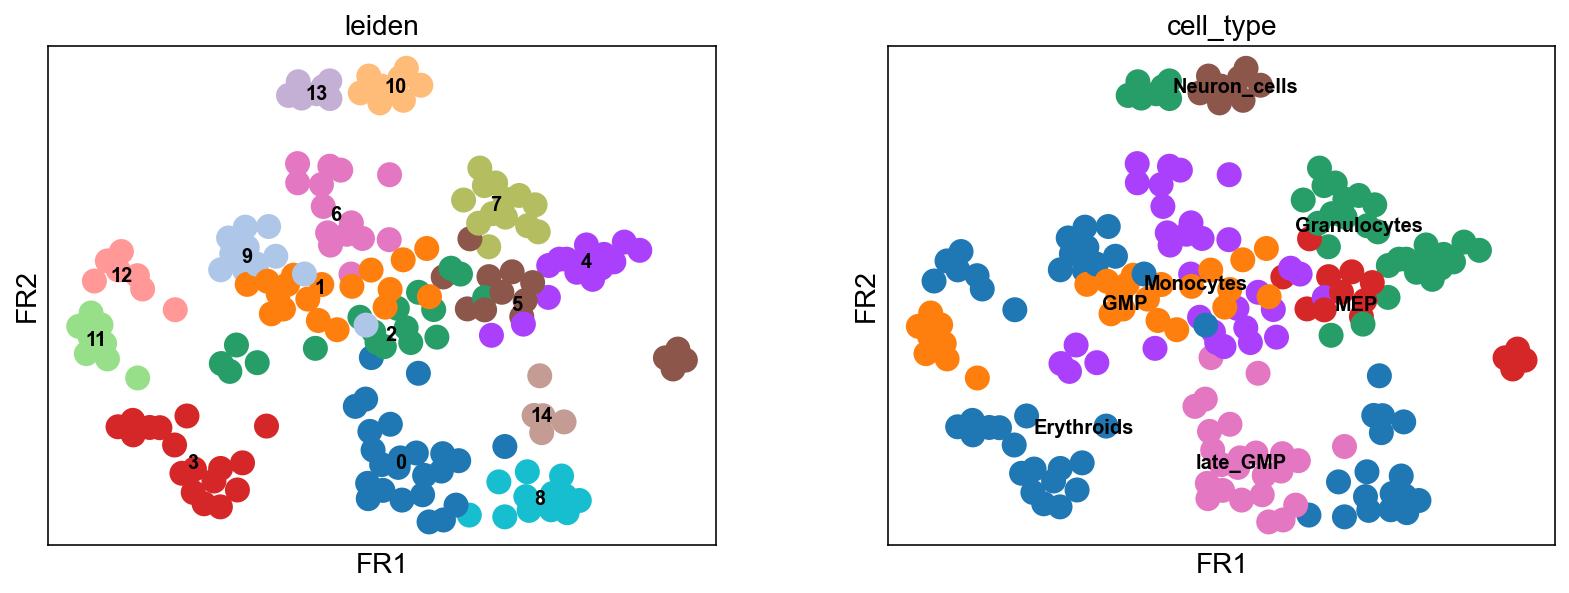

In [115]:
#10.2. Make annotation (2)
#We'll also annotate the indivisual Louvain clusters.

sc.pl.draw_graph(FCneg_mouse2, color=['leiden', 'cell_type'],
                 legend_loc='on data')

In [116]:
#!! Please change the dictionary below depending on the clustering results. The results may change depending on the execution environment.
annotation_2 = {'5': 'MEP_0',
                '15': 'Ery_0',
                '10': 'Ery_1',
                '16': 'Ery_2',
                '14': 'Ery_3',
                '9': 'Ery_4',
                '8': 'Ery_5',
                '19': 'Ery_6',
                '3': 'Ery_7',
                '12': 'Ery_8',
                '18': 'Ery_9',
                '17': 'Mk_0',
                '22': 'Mk_0',
                '11': 'GMP_0',
                '1': 'GMP_1',
                '0': 'GMPl_0',
                '7': 'Gran_0',
                '13': 'Gran_1',
                '4': 'Gran_2',
                '6': 'Mo_0',
                '2': 'Mo_1',
                '21': 'DC_0',
                '20': 'Lym_0'}

In [117]:
FCneg_mouse2.obs["louvain_annot"] = [annotation_2[i] for i in FCneg_mouse2.obs.louvain]

... storing 'louvain_annot' as categorical


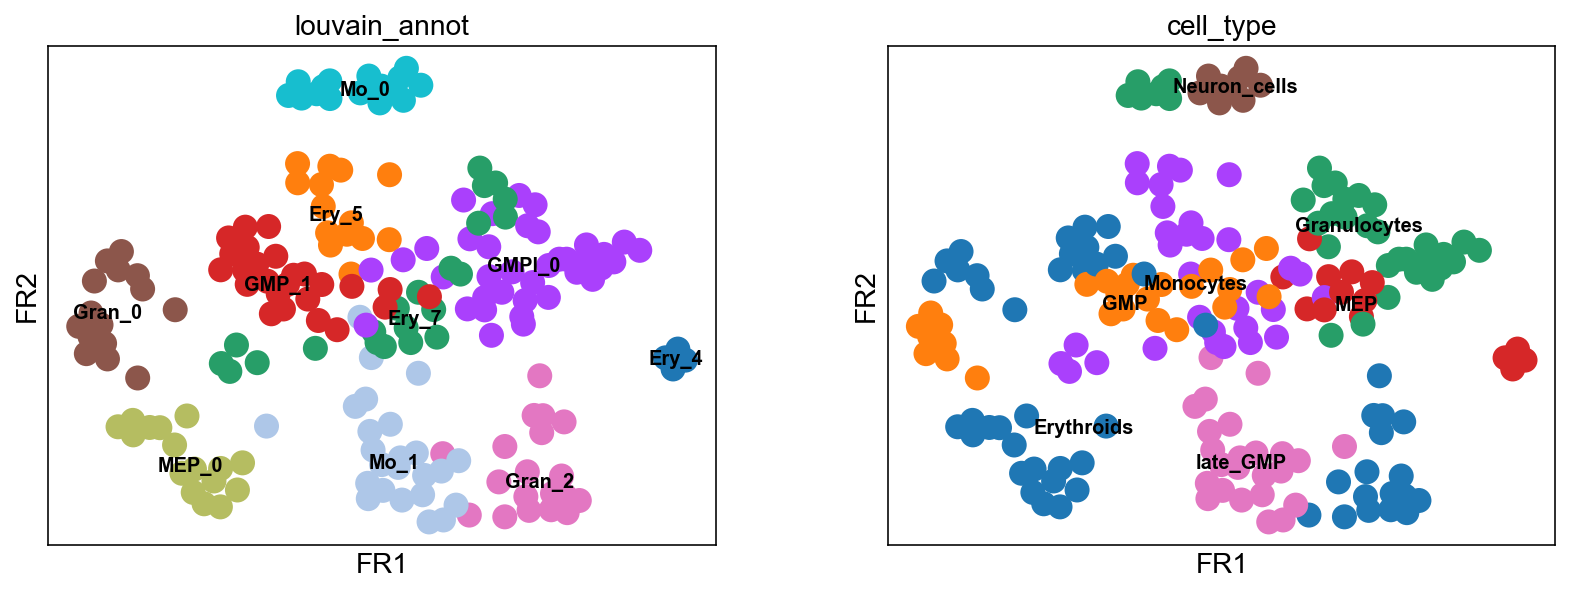

In [118]:
sc.pl.draw_graph(FCneg_mouse2, color=['louvain_annot', 'cell_type'],
                 legend_loc='on data')

In [119]:
#11. [Optional step] Subset cells
FCneg_mouse2.obs.cell_type.unique()

['GMP', 'Monocytes', 'Erythroids', 'late_GMP', 'Granulocytes', 'MEP', 'Neuron_cells']
Categories (7, object): ['GMP', 'Monocytes', 'Erythroids', 'late_GMP', 'Granulocytes', 'MEP', 'Neuron_cells']

In [120]:
cell_of_interest = FCneg_mouse2.obs.index[~FCneg_mouse2.obs.cell_type.isin(["Lymphoid", "DC"])]
FCneg_mouse2 = FCneg_mouse2[cell_of_interest, :]

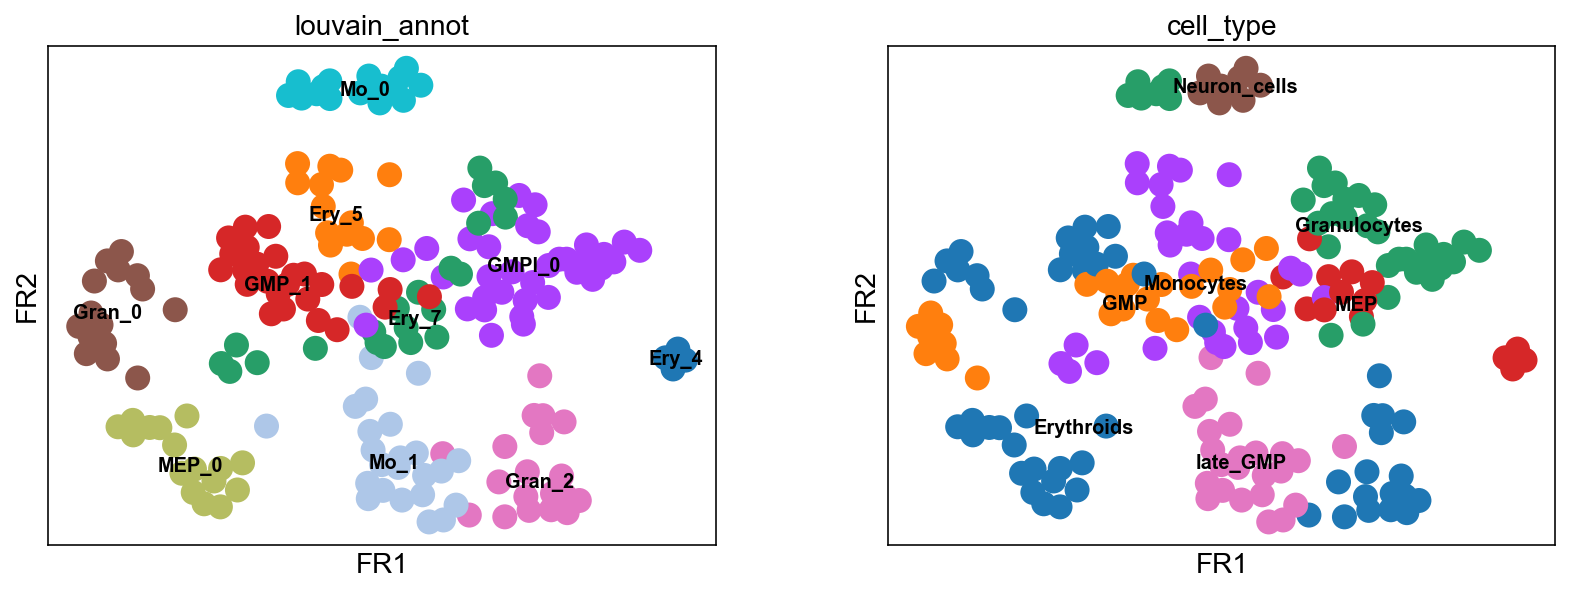

In [121]:
# check result
sc.pl.draw_graph(FCneg_mouse2, color=['louvain_annot', 'cell_type'],
                 legend_loc='on data')

In [128]:
#12. Save processed data
FCneg_mouse2.write_h5ad("data/FCneg_mouse2.h5ad")